In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import asyncio
import itertools
from datetime import datetime
from IPython import display
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import vectorbt as vbt
import plotly.graph_objects as go
import mt4_hst
%matplotlib inline

In [2]:
cheight, cwidth = 500, 1000 # Adjust as needed for Chart Height and Width
vbt.settings.set_theme("dark") # Options: "light" (Default), "dark" (my fav), "seaborn"

# Must be set
vbt.settings.portfolio["freq"] = "1D" # Daily

# Predefine vectorbt Portfolio settings
vbt.settings.portfolio["init_cash"] = 1e4
vbt.settings.portfolio["fees"] = 0.0015 # 0.25%
vbt.settings.portfolio["slippage"] = 0.0015 # 0.25%
vbt.settings.portfolio["size"] = 100
# vbt.settings.portfolio["accumulate"] = False
vbt.settings.portfolio["allow_partial"] = False

pf_settings = pd.DataFrame(vbt.settings.portfolio.items(), columns=["Option", "Value"])
pf_settings.set_index("Option", inplace=True)

print(f"Portfolio Settings [Initial]")
pf_settings

Portfolio Settings [Initial]


,Value
Option,
call_seq,default
init_cash,10000.0
size,100
size_type,amount
fees,0.0015
fixed_fees,0.0
slippage,0.0015
reject_prob,0.0
min_size,0.0


In [3]:
# Example Long Trends for the selected Asset
# * Uncomment others for exploration or replace them with your own TA Trend Strategy
def trends(df: pd.DataFrame):
    df['close>sma50'] = (df['close'] > df.ta.sma(50)).astype(int)
    df['ema10>ema20'] = (df.ta.ema(10) > df.ta.ema(20)).astype(int)
    donchian_20 = ta.donchian(df['high'], df['close'], lower_length=20, upper_length=20)
    donchian_50 = ta.donchian(df['high'], df['close'], lower_length=50, upper_length=50)
    df['higher_low'] = (donchian_20['DCL_20_20'] > donchian_50['DCL_50_50']).astype(int)
    return (df['close>sma50'] & df['ema10>ema20'] & df['higher_low'])
    # return ta.ma(mamode, df.close, length=fast) > ta.ma(mamode, df.close, length=slow) # SMA(fast) > SMA(slow) "Golden/Death Cross"
#     return ta.increasing(ta.ma(mamode, df.close, length=fast)) # Increasing MA(fast)
#     return ta.macd(df.close, fast, slow).iloc[:,1] > 0 # MACD Histogram is positive

In [4]:
df = mt4_hst.read_hst("stock_env/datasets/FPT1440.hst")
df = df[df['time'] >= '2012-01-01']
df.index = df['time']

In [5]:
df['close>sma50'] = (df['close'] > df.ta.sma(50)).astype(int)
df['ema10>ema20'] = (df.ta.ema(10) > df.ta.ema(20)).astype(int)
donchian_20 = ta.donchian(df['high'], df['close'], lower_length=20, upper_length=20)
donchian_50 = ta.donchian(df['high'], df['close'], lower_length=50, upper_length=50)
df['higher_low'] = (donchian_20['DCL_20_20'] > donchian_50['DCL_50_50']).astype(int)

In [6]:
asset_trends = trends(df)
asset_signals = df.ta.tsignals(asset_trends, asbool=True, append=True)
asset_signals.tail()

,TS_Trends,TS_Trades,TS_Entries,TS_Exits
time,,,,
2022-07-19,False,0,False,False
2022-07-20,False,0,False,False
2022-07-21,False,0,False,False
2022-07-22,False,0,False,False
2022-07-25,False,0,False,False


In [7]:
# Asset Portfolio from Trade Signals
assetpf_signals = vbt.Portfolio.from_signals(
    df.close,
    entries=asset_signals.TS_Entries,
    exits=asset_signals.TS_Exits,
)

In [8]:
# assetpf_signals.trades.plot(height=cheight, width=cwidth).show_png()

In [9]:
fig = df.close.vbt.plot(trace_kwargs=dict(name='Close'))
assetpf_signals.positions.plot(close_trace_kwargs=dict(visible=False), fig=fig)

FigureWidget({
    'data': [{'name': 'Close',
              'showlegend': True,
              'type': 'scatter…

In [10]:
values = assetpf_signals.value()
values.index = df['time']
returns = values.pct_change()


    Annual return     :  3.69%
    Cumulative return :  46.10%
    Sharpe ratio      :  0.66
    Maximum Drawdown  : -10.47%
    Annual Volatility :  5.72%
    Value-At-Risk     :  nan%
    


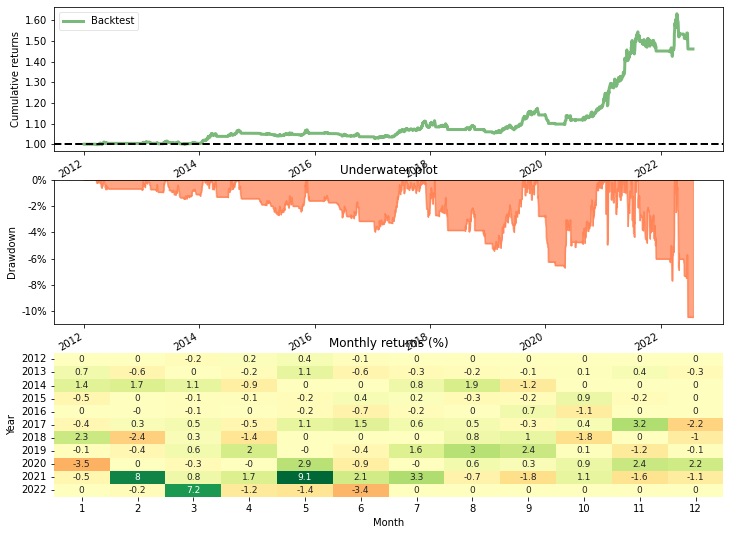

In [11]:
from stock_env.utils import create_performance
create_performance(returns)

In [12]:
pd.DataFrame(assetpf_signals.positions.values).head()

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,parent_id
0,0,0,100.0,49,8.044277,1.206642,101,8.458194,1.268729,38.916367,0.048378,0,1,0
1,1,0,100.0,250,6.658445,0.998767,284,6.729688,1.009453,5.116068,0.007684,0,1,1
2,2,0,100.0,309,7.079171,1.061876,318,6.893827,1.034074,-20.630394,-0.029142,0,1,2
3,3,0,100.0,335,7.024294,1.053644,365,7.550382,1.132557,50.422596,0.071783,0,1,3
4,4,0,100.0,374,7.865745,1.179862,375,7.769233,1.165385,-11.996481,-0.015252,0,1,4
